In [11]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import random
import os
import sys
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

random.seed(12306)
np.random.seed(12306)
tf.random.set_seed(12306)

In [80]:
X_train = pd.read_excel('Xtrain.xlsx',index_col=0)
y_train = pd.read_excel('ytrain.xlsx',index_col=0)
X_test = pd.read_excel('Xtest.xlsx',index_col=0)
y_test = pd.read_excel('ytest.xlsx',index_col=0)

X_train.drop(['sample_id'],axis=1,inplace=True)
X_test.drop(['sample_id'],axis=1,inplace=True)

selected_features = ['Succinate_neg-079', 'Uridine_neg-088', 'Lactic acid_neg-055', 'S-Adenosyl-methionine_pos-139', 'Pyroglutamic acid_neg-072', '2-Aminooctanoic acid_pos-006', 'Neopterin_pos-117', 'N-Acetyl-D-glucosamine 6-phosphate_neg-061', 'Serotonin_pos-142', 'NMN_pos-162']
X_train_10dm = X_train[selected_features]
X_test_10dm = X_test[selected_features]

X_external = pd.read_excel('Xexternal_test.xlsx')
y_external = pd.read_excel('yexternal_test.xlsx')
X_external.drop(columns=['sample_id', 'Unnamed: 0'], axis=1, inplace=True)
X_external_10dm = X_external[selected_features]
y_external = pd.DataFrame(y_external['state'])
X_train_new = pd.concat([X_train, X_external], ignore_index=True)
y_train_new = pd.concat([y_train, y_external], ignore_index=True)
X_train_new_10dm = X_train_new[selected_features]

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_external_scaled = scaler.transform(X_external)

scaler = StandardScaler()
scaler.fit(X_train_10dm)
X_train_10dm_scaled = scaler.transform(X_train_10dm)
X_test_10dm_scaled = scaler.transform(X_test_10dm)
X_external_10dm_scaled = scaler.transform(X_external_10dm)

scaler_all = StandardScaler()
scaler_all.fit(X_train_new)
X_train_new = scaler_all.transform(X_train_new)
X_test = scaler_all.transform(X_test)

scaler_10dm = StandardScaler()
scaler_10dm.fit(X_train_new_10dm)
X_train_new_10dm = scaler_10dm.transform(X_train_new_10dm)
X_test_10dm = scaler_10dm.transform(X_test_10dm)

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)
y_train_new_encoded = to_categorical(y_train_new)

# *Model Evaluation for Original Split* #

In [82]:
def evaluate_model(X_train, X_test, X_external, y_train, y_test, y_external, input_size=10, layer1=[True, 40], layer2=[True, 395], layer3=[True, 700], layer4=[True, 65], layer5=[True, 20], epochs=200, batch=30, rate=0.001, pca=False, n_pc=20, quietly=False):
    model = Sequential()
    
    model.add(Input(shape=(input_size,)))

    if layer1[0] == True:
        model.add(Dense(layer1[1]))
        model.add(Activation('relu'))
        model.add(Dropout(layer1[2]))

    if layer2[0] == True:
        model.add(Dense(layer2[1]))
        model.add(Activation('relu'))
        model.add(Dropout(layer2[2]))

    if layer3[0] == True:
        model.add(Dense(layer3[1]))
        model.add(Activation('relu'))
        model.add(Dropout(layer3[2]))

    if layer4[0] == True:
        model.add(Dense(layer4[1]))
        model.add(Activation('relu'))
        model.add(Dropout(layer4[2]))

    if layer5[0] == True:
        model.add(Dense(layer5[1]))
        model.add(Activation('relu'))
        model.add(Dropout(layer5[2]))
   
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=rate), metrics=['accuracy'])
    model.summary()

    if pca == True:
        pca_model = PCA(n_components=n_pc)
        pca_model.fit(X_train) 
        X_train = pca_model.transform(X_train)
        X_test = pca_model.transform(X_test)
        X_external = pca_model.transform(X_external)

    history = model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    ext_loss, ext_acc = model.evaluate(X_external, y_external, verbose=0)
    print(f"Test Accuracy: {test_acc}")
    print(f"External Test Accuracy: {ext_acc}")

    return test_acc, ext_acc

# *Top 10 Metabolites Original Training* #

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_128 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_128 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_129 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,401 (9.38 KB)

 Trainable params: 2,401 (9.38 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045
External Test Accuracy: 0.8105263113975525


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_130 (Dense)               │ (None, 400)            │         4,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_130 (Activation)     │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 1)              │           401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_131 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045
External Test Accuracy: 0.800000011920929


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_132 (Dense)               │ (None, 600)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_132 (Activation)     │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_133 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,201 (28.13 KB)

 Trainable params: 7,201 (28.13 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045
External Test Accuracy: 0.8315789699554443


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_134 (Dense)               │ (None, 800)            │         8,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_134 (Activation)     │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 1)              │           801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_135 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,601 (37.50 KB)

 Trainable params: 9,601 (37.50 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369
External Test Accuracy: 0.8105263113975525


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_136 (Dense)               │ (None, 1000)           │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_136 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_137 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,001 (46.88 KB)

 Trainable params: 12,001 (46.88 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045
External Test Accuracy: 0.8421052694320679


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_138 (Dense)               │ (None, 1200)           │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_138 (Activation)     │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │         1,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_139 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,401 (56.25 KB)

 Trainable params: 14,401 (56.25 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369
External Test Accuracy: 0.8315789699554443


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 1400)           │        15,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_140 (Activation)     │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 1)              │         1,401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_141 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,801 (65.63 KB)

 Trainable params: 16,801 (65.63 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369
External Test Accuracy: 0.8315789699554443


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_142 (Dense)               │ (None, 1600)           │        17,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_142 (Activation)     │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1)              │         1,601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_143 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,201 (75.00 KB)

 Trainable params: 19,201 (75.00 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045
External Test Accuracy: 0.821052610874176


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 1800)           │        19,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_144 (Activation)     │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 1)              │         1,801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_145 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,601 (84.38 KB)

 Trainable params: 21,601 (84.38 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369
External Test Accuracy: 0.8421052694320679


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_146 (Dense)               │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_146 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 1)              │         2,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_147 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,001 (93.75 KB)

 Trainable params: 24,001 (93.75 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569
External Test Accuracy: 0.8526315689086914


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_148 (Dense)               │ (None, 2200)           │        24,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_148 (Activation)     │ (None, 2200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 2200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 1)              │         2,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_149 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,401 (103.13 KB)

 Trainable params: 26,401 (103.13 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569
External Test Accuracy: 0.8315789699554443


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_150 (Dense)               │ (None, 2400)           │        26,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_150 (Activation)     │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 1)              │         2,401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_151 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,801 (112.50 KB)

 Trainable params: 28,801 (112.50 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569
External Test Accuracy: 0.8421052694320679


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_152 (Dense)               │ (None, 2600)           │        28,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_152 (Activation)     │ (None, 2600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 2600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 1)              │         2,601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_153 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,201 (121.88 KB)

 Trainable params: 31,201 (121.88 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569
External Test Accuracy: 0.8421052694320679


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_154 (Dense)               │ (None, 2800)           │        30,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_154 (Activation)     │ (None, 2800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 2800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 1)              │         2,801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_155 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569
External Test Accuracy: 0.8421052694320679


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_156 (Dense)               │ (None, 3000)           │        33,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_156 (Activation)     │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 1)              │         3,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_157 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,001 (140.63 KB)

 Trainable params: 36,001 (140.63 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569
External Test Accuracy: 0.8421052694320679


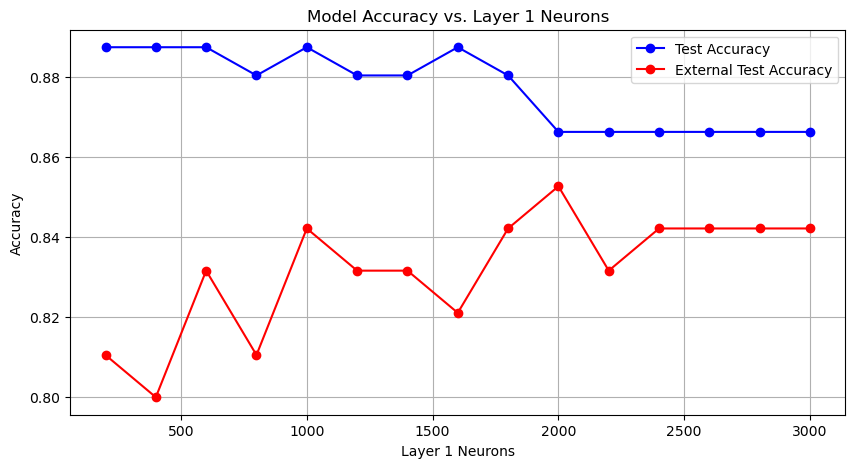

In [68]:
test_accuracies = []
ext_accuracies = []
num_neurons = []
for neurons in range(200, 3001, 200):  # Directly iterate over the range without wrapping it in a list
    test_acc, ext_acc = evaluate_model(X_train_10dm_scaled, X_test_10dm_scaled, X_external_10dm_scaled, y_train, y_test, y_external, layer1=[True, neurons, 0], layer2 = [False], layer3=[False], layer4=[False], layer5=[False], quietly=True)
    test_accuracies.append(test_acc)
    ext_accuracies.append(ext_acc)
    num_neurons.append(neurons)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_neurons, test_accuracies, marker='o', linestyle='-', color='b')
plt.plot(num_neurons, ext_accuracies, marker='o', linestyle='-', color='r')
plt.title('Model Accuracy vs. Layer 1 Neurons')
plt.xlabel('Layer 1 Neurons')
plt.ylabel('Accuracy')
labels = ['Test Accuracy', 'External Test Accuracy']
plt.legend(labels)
plt.grid(True)
plt.show()

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_188 (Dense)               │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_188 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 300)            │       600,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_189 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 1)              │           301 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_190 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,601 (2.38 MB)

 Trainable params: 622,601 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8591549396514893
External Test Accuracy: 0.8315789699554443


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_191 (Dense)               │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_191 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 600)            │     1,200,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_192 (Activation)     │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_193 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,223,201 (4.67 MB)

 Trainable params: 1,223,201 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8591549396514893
External Test Accuracy: 0.8315789699554443


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_194 (Dense)               │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_194 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 900)            │     1,800,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_195 (Activation)     │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 1)              │           901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_196 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,823,801 (6.96 MB)

 Trainable params: 1,823,801 (6.96 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8732394576072693
External Test Accuracy: 0.821052610874176


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_197 (Dense)               │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_197 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 1200)           │     2,401,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_198 (Activation)     │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 1)              │         1,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_199 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,424,401 (9.25 MB)

 Trainable params: 2,424,401 (9.25 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8732394576072693
External Test Accuracy: 0.821052610874176


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_200 (Dense)               │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_200 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 1500)           │     3,001,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_201 (Activation)     │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 1)              │         1,501 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_202 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,025,001 (11.54 MB)

 Trainable params: 3,025,001 (11.54 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569
External Test Accuracy: 0.8315789699554443


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_203 (Dense)               │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_203 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 1800)           │     3,601,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_204 (Activation)     │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 1)              │         1,801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_205 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,625,601 (13.83 MB)

 Trainable params: 3,625,601 (13.83 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569
External Test Accuracy: 0.8315789699554443


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_206 (Dense)               │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_206 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 2100)           │     4,202,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_207 (Activation)     │ (None, 2100)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 2100)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 1)              │         2,101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_208 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,226,201 (16.12 MB)

 Trainable params: 4,226,201 (16.12 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8450704216957092
External Test Accuracy: 0.8105263113975525


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_209 (Dense)               │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_209 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 2400)           │     4,802,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_210 (Activation)     │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 1)              │         2,401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_211 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,826,801 (18.41 MB)

 Trainable params: 4,826,801 (18.41 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8521126508712769
External Test Accuracy: 0.821052610874176


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_212 (Dense)               │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_212 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 2700)           │     5,402,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_213 (Activation)     │ (None, 2700)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 2700)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 1)              │         2,701 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_214 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,427,401 (20.70 MB)

 Trainable params: 5,427,401 (20.70 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8450704216957092
External Test Accuracy: 0.821052610874176


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_215 (Dense)               │ (None, 2000)           │        22,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_215 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 3000)           │     6,003,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_216 (Activation)     │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 1)              │         3,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_217 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,028,001 (22.99 MB)

 Trainable params: 6,028,001 (22.99 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369
External Test Accuracy: 0.8315789699554443


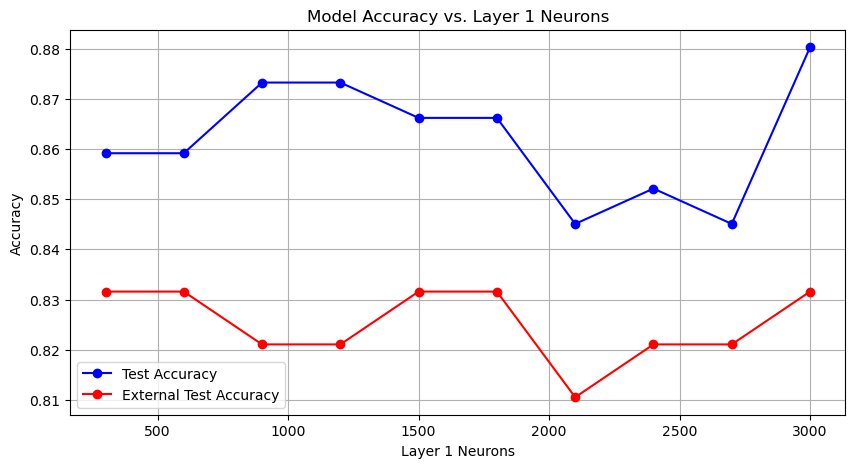

In [70]:
test_accuracies = []
ext_accuracies = []
num_neurons = []
for neurons in range(300, 3001, 300):  # Directly iterate over the range without wrapping it in a list
    test_acc, ext_acc = evaluate_model(X_train_10dm_scaled, X_test_10dm_scaled, X_external_10dm_scaled, y_train, y_test, y_external, layer1=[True, 2000, 0], layer2 = [True, neurons, 0], layer3=[False], layer4=[False], layer5=[False], quietly=True)
    test_accuracies.append(test_acc)
    ext_accuracies.append(ext_acc)
    num_neurons.append(neurons)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_neurons, test_accuracies, marker='o', linestyle='-', color='b')
plt.plot(num_neurons, ext_accuracies, marker='o', linestyle='-', color='r')
plt.title('Model Accuracy vs. Layer 1 Neurons')
plt.xlabel('Layer 1 Neurons')
plt.ylabel('Accuracy')
labels = ['Test Accuracy', 'External Test Accuracy']
plt.legend(labels)
plt.grid(True)
plt.show()

# *PCA for Original Split* #

Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_222 (Dense)               │ (None, 200)            │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_222 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_223 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,401 (48.44 KB)

 Trainable params: 12,401 (48.44 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177
External Test Accuracy: 0.8631578683853149


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)               │ (None, 400)            │        24,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_224 (Activation)     │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 1)              │           401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_225 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801 (96.88 KB)

 Trainable params: 24,801 (96.88 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123
External Test Accuracy: 0.8526315689086914


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_226 (Dense)               │ (None, 600)            │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_226 (Activation)     │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_227 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,201 (145.32 KB)

 Trainable params: 37,201 (145.32 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9154929518699646
External Test Accuracy: 0.8631578683853149


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_228 (Dense)               │ (None, 800)            │        48,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_228 (Activation)     │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 1)              │           801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_229 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,601 (193.75 KB)

 Trainable params: 49,601 (193.75 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123
External Test Accuracy: 0.8631578683853149


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_230 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_230 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_231 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9295774698257446
External Test Accuracy: 0.8736842274665833


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_232 (Dense)               │ (None, 1200)           │        73,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_232 (Activation)     │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 1)              │         1,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_233 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,401 (290.63 KB)

 Trainable params: 74,401 (290.63 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9154929518699646
External Test Accuracy: 0.8526315689086914


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_234 (Dense)               │ (None, 1400)           │        85,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_234 (Activation)     │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 1)              │         1,401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_235 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,801 (339.07 KB)

 Trainable params: 86,801 (339.07 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177
External Test Accuracy: 0.8631578683853149


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_236 (Dense)               │ (None, 1600)           │        97,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_236 (Activation)     │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 1)              │         1,601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_237 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,201 (387.50 KB)

 Trainable params: 99,201 (387.50 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177
External Test Accuracy: 0.8736842274665833


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_238 (Dense)               │ (None, 1800)           │       109,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_238 (Activation)     │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 1)              │         1,801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_239 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,601 (435.94 KB)

 Trainable params: 111,601 (435.94 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177
External Test Accuracy: 0.8526315689086914


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_240 (Dense)               │ (None, 2000)           │       122,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_240 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 1)              │         2,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_241 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,001 (484.38 KB)

 Trainable params: 124,001 (484.38 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177
External Test Accuracy: 0.8736842274665833


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_242 (Dense)               │ (None, 2200)           │       134,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_242 (Activation)     │ (None, 2200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 2200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 1)              │         2,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_243 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,401 (532.82 KB)

 Trainable params: 136,401 (532.82 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9154929518699646
External Test Accuracy: 0.8631578683853149


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_244 (Dense)               │ (None, 2400)           │       146,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_244 (Activation)     │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 1)              │         2,401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_245 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,801 (581.25 KB)

 Trainable params: 148,801 (581.25 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9295774698257446
External Test Accuracy: 0.8631578683853149


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_246 (Dense)               │ (None, 2600)           │       158,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_246 (Activation)     │ (None, 2600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 2600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 1)              │         2,601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_247 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,201 (629.69 KB)

 Trainable params: 161,201 (629.69 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9295774698257446
External Test Accuracy: 0.8631578683853149


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_248 (Dense)               │ (None, 2800)           │       170,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_248 (Activation)     │ (None, 2800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 2800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 1)              │         2,801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_249 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,601 (678.13 KB)

 Trainable params: 173,601 (678.13 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123
External Test Accuracy: 0.8631578683853149


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_250 (Dense)               │ (None, 3000)           │       183,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_250 (Activation)     │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 1)              │         3,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_251 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,001 (726.57 KB)

 Trainable params: 186,001 (726.57 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9295774698257446
External Test Accuracy: 0.8631578683853149


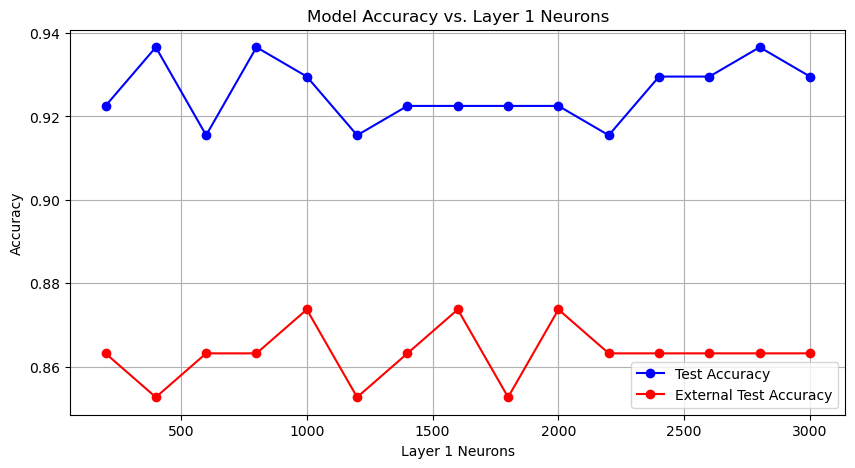

In [83]:
test_accuracies = []
ext_accuracies = []
num_neurons = []
for neurons in range(200, 3001, 200):  # Directly iterate over the range without wrapping it in a list
    test_acc, ext_acc = evaluate_model(X_train_scaled, X_test_scaled, X_external_scaled, y_train, y_test, y_external, layer1=[True, neurons, 0], layer2 = [False], layer3=[False], layer4=[False], layer5=[False], quietly=True, input_size=60, pca=True, n_pc=60)
    test_accuracies.append(test_acc)
    ext_accuracies.append(ext_acc)
    num_neurons.append(neurons)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_neurons, test_accuracies, marker='o', linestyle='-', color='b')
plt.plot(num_neurons, ext_accuracies, marker='o', linestyle='-', color='r')
plt.title('Model Accuracy vs. Layer 1 Neurons')
plt.xlabel('Layer 1 Neurons')
plt.ylabel('Accuracy')
labels = ['Test Accuracy', 'External Test Accuracy']
plt.legend(labels)
plt.grid(True)
plt.show()

Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_252 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_252 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 200)            │       200,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_253 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_254 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,401 (1021.10 KB)

 Trainable params: 261,401 (1021.10 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9154929518699646
External Test Accuracy: 0.8736842274665833


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_255 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_255 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 400)            │       400,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_256 (Activation)     │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 1)              │           401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_257 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,801 (1.76 MB)

 Trainable params: 461,801 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9295774698257446
External Test Accuracy: 0.8842105269432068


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_258 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_258 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 600)            │       600,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_259 (Activation)     │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_260 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,201 (2.53 MB)

 Trainable params: 662,201 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9295774698257446
External Test Accuracy: 0.8631578683853149


Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_261 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_261 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_152 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 800)            │       800,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_262 (Activation)     │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 1)              │           801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_263 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 862,601 (3.29 MB)

 Trainable params: 862,601 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177
External Test Accuracy: 0.8842105269432068


Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_264 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_264 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_265 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_266 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,063,001 (4.06 MB)

 Trainable params: 1,063,001 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9154929518699646
External Test Accuracy: 0.8842105269432068


Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_267 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_267 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 1200)           │     1,201,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_268 (Activation)     │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 1)              │         1,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_269 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,263,401 (4.82 MB)

 Trainable params: 1,263,401 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9436619877815247
External Test Accuracy: 0.8947368264198303


Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_270 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_270 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 1400)           │     1,401,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_271 (Activation)     │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ (None, 1400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 1)              │         1,401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_272 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,463,801 (5.58 MB)

 Trainable params: 1,463,801 (5.58 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177
External Test Accuracy: 0.8631578683853149


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_273 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_273 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 1600)           │     1,601,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_274 (Activation)     │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_161 (Dropout)           │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 1)              │         1,601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_275 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,664,201 (6.35 MB)

 Trainable params: 1,664,201 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9295774698257446
External Test Accuracy: 0.8631578683853149


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_276 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_276 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 1800)           │     1,801,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_277 (Activation)     │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 1)              │         1,801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_278 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,864,601 (7.11 MB)

 Trainable params: 1,864,601 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9154929518699646
External Test Accuracy: 0.9052631855010986


Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_279 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_279 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_280 (Dense)               │ (None, 2000)           │     2,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_280 (Activation)     │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 1)              │         2,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_281 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,065,001 (7.88 MB)

 Trainable params: 2,065,001 (7.88 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9154929518699646
External Test Accuracy: 0.8736842274665833


Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_282 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_282 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 2200)           │     2,202,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_283 (Activation)     │ (None, 2200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 2200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 1)              │         2,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_284 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,401 (8.64 MB)

 Trainable params: 2,265,401 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177
External Test Accuracy: 0.8526315689086914


Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_285 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_285 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 2400)           │     2,402,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_286 (Activation)     │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 1)              │         2,401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_287 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,465,801 (9.41 MB)

 Trainable params: 2,465,801 (9.41 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9014084339141846
External Test Accuracy: 0.8842105269432068


Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_288 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_288 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 2600)           │     2,602,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_289 (Activation)     │ (None, 2600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 2600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 1)              │         2,601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_290 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,666,201 (10.17 MB)

 Trainable params: 2,666,201 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177
External Test Accuracy: 0.8842105269432068


Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_291 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_291 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 2800)           │     2,802,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_292 (Activation)     │ (None, 2800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 2800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 1)              │         2,801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_293 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,866,601 (10.94 MB)

 Trainable params: 2,866,601 (10.94 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177
External Test Accuracy: 0.9052631855010986


Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_294 (Dense)               │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_294 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_295 (Dense)               │ (None, 3000)           │     3,003,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_295 (Activation)     │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 1)              │         3,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_296 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067,001 (11.70 MB)

 Trainable params: 3,067,001 (11.70 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9295774698257446
External Test Accuracy: 0.8842105269432068


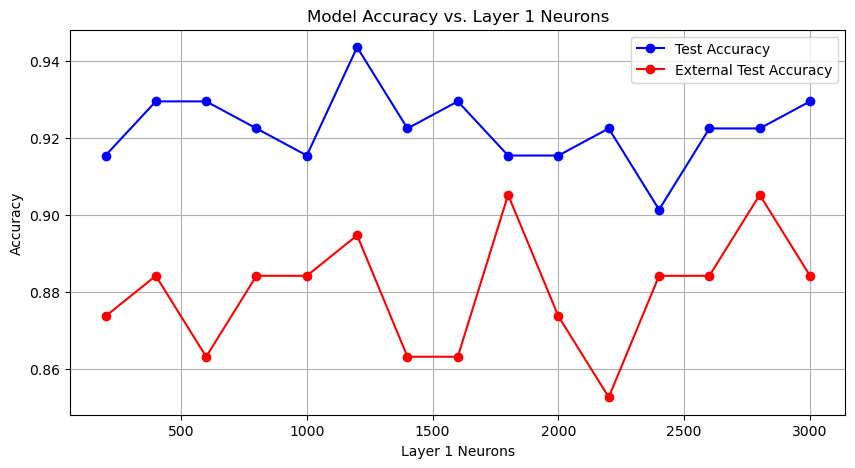

In [84]:
test_accuracies = []
ext_accuracies = []
num_neurons = []
for neurons in range(200, 3001, 200):  # Directly iterate over the range without wrapping it in a list
    test_acc, ext_acc = evaluate_model(X_train_scaled, X_test_scaled, X_external_scaled, y_train, y_test, y_external, layer1=[True, 1000, 0], layer2 = [True, neurons, 0], layer3=[False], layer4=[False], layer5=[False], quietly=True, input_size=60, pca=True, n_pc=60)
    test_accuracies.append(test_acc)
    ext_accuracies.append(ext_acc)
    num_neurons.append(neurons)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_neurons, test_accuracies, marker='o', linestyle='-', color='b')
plt.plot(num_neurons, ext_accuracies, marker='o', linestyle='-', color='r')
plt.title('Model Accuracy vs. Layer 1 Neurons')
plt.xlabel('Layer 1 Neurons')
plt.ylabel('Accuracy')
labels = ['Test Accuracy', 'External Test Accuracy']
plt.legend(labels)
plt.grid(True)
plt.show()

# *Model Evalutaion for New Split* #

In [85]:
def evaluate_deep_model(X_train, X_test, y_train, y_test, input_size=10, layer1=[True, 40], layer2=[True, 395], layer3=[True, 700], layer4=[True, 65], layer5=[True, 20], epochs=200, batch=30, rate=0.001, pca=False, n_pc=20, quietly=False):
    model = Sequential()
    
    model.add(Input(shape=(input_size,)))

    if layer1[0] == True:
        model.add(Dense(layer1[1]))
        model.add(Activation('relu'))
        model.add(Dropout(layer1[2]))

    if layer2[0] == True:
        model.add(Dense(layer2[1]))
        model.add(Activation('relu'))
        model.add(Dropout(layer2[2]))

    if layer3[0] == True:
        model.add(Dense(layer3[1]))
        model.add(Activation('relu'))
        model.add(Dropout(layer3[2]))

    if layer4[0] == True:
        model.add(Dense(layer4[1]))
        model.add(Activation('relu'))
        model.add(Dropout(layer4[2]))

    if layer5[0] == True:
        model.add(Dense(layer5[1]))
        model.add(Activation('relu'))
        model.add(Dropout(layer5[2]))
   
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=rate), metrics=['accuracy'])
    model.summary()

    if pca == True:
        pca_model = PCA(n_components=n_pc)
        pca_model.fit(X_train) 
        X_train = pca_model.transform(X_train)
        X_test = pca_model.transform(X_test)

    history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc}")

    return test_acc

# *Top 10 Metabolites New Training* #

Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_297 (Dense)               │ (None, 100)            │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_297 (Activation)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_298 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,201 (4.69 KB)

 Trainable params: 1,201 (4.69 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045


Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_299 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_299 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_300 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_300 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,401 (9.38 KB)

 Trainable params: 2,401 (9.38 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_301 (Dense)               │ (None, 300)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_301 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 1)              │           301 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_302 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,601 (14.07 KB)

 Trainable params: 3,601 (14.07 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8732394576072693


Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_303 (Dense)               │ (None, 400)            │         4,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_303 (Activation)     │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_179 (Dropout)           │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 1)              │           401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_304 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8732394576072693


Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_305 (Dense)               │ (None, 500)            │         5,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_305 (Activation)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 1)              │           501 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_306 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,001 (23.44 KB)

 Trainable params: 6,001 (23.44 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_307 (Dense)               │ (None, 600)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_307 (Activation)     │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_308 (Dense)               │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_308 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,201 (28.13 KB)

 Trainable params: 7,201 (28.13 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_309 (Dense)               │ (None, 700)            │         7,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_309 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_310 (Dense)               │ (None, 1)              │           701 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_310 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401 (32.82 KB)

 Trainable params: 8,401 (32.82 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8732394576072693


Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_311 (Dense)               │ (None, 800)            │         8,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_311 (Activation)     │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_312 (Dense)               │ (None, 1)              │           801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_312 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,601 (37.50 KB)

 Trainable params: 9,601 (37.50 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_313 (Dense)               │ (None, 900)            │         9,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_313 (Activation)     │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 1)              │           901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_314 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,801 (42.19 KB)

 Trainable params: 10,801 (42.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_315 (Dense)               │ (None, 1000)           │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_315 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_185 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_316 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,001 (46.88 KB)

 Trainable params: 12,001 (46.88 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


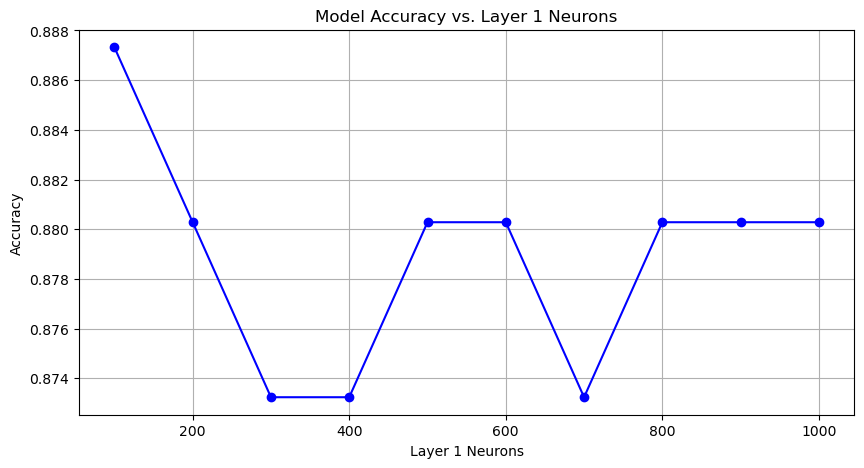

In [86]:
accuracies = []
num_neurons = []
for neurons in range(100, 1001, 100):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new_10dm, X_test_10dm, y_train_new, y_test, layer1=[True, neurons, 0], layer2 = [False], layer3=[False], layer4=[False], layer5=[False], quietly=True)
    accuracies.append(acc)
    num_neurons.append(neurons)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_neurons, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Layer 1 Neurons')
plt.xlabel('Layer 1 Neurons')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_70 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_71 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_72 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,401 (87.50 KB)

 Trainable params: 22,401 (87.50 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_73 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_74 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_75 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,601 (166.41 KB)

 Trainable params: 42,601 (166.41 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8521126508712769


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_76 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_77 (Activation)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │           301 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_78 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,801 (245.32 KB)

 Trainable params: 62,801 (245.32 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_79 (Dense)                │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_79 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 400)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_80 (Activation)      │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │           401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_81 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,001 (324.22 KB)

 Trainable params: 83,001 (324.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_82 (Dense)                │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_82 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 500)            │       100,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_83 (Activation)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │           501 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_84 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,201 (403.13 KB)

 Trainable params: 103,201 (403.13 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8591549396514893


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_85 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 600)            │       120,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_86 (Activation)      │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_87 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,401 (482.04 KB)

 Trainable params: 123,401 (482.04 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8732394576072693


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_88 (Dense)                │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_88 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_89 (Activation)      │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │           701 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_90 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,601 (560.94 KB)

 Trainable params: 143,601 (560.94 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8943662047386169


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_91 (Dense)                │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_91 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 800)            │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_92 (Activation)      │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │           801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_93 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,801 (639.85 KB)

 Trainable params: 163,801 (639.85 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_94 (Dense)                │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_94 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 900)            │       180,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_95 (Activation)      │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 1)              │           901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_96 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,001 (718.75 KB)

 Trainable params: 184,001 (718.75 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


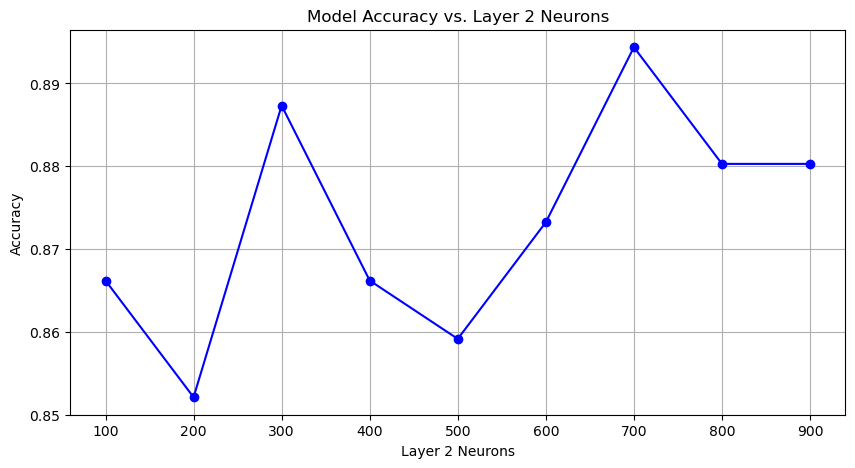

In [16]:
accuracies = []
num_neurons = []
for neurons in range(100, 1000, 100):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new_10dm, X_test_10dm, y_train_new, y_test, layer1=[True, 200, 0], layer2 = [True, neurons, 0], layer3=[False], layer4=[False], layer5=[False])
    accuracies.append(acc)
    num_neurons.append(neurons)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_neurons, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Layer 2 Neurons')
plt.xlabel('Layer 2 Neurons')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Model: "sequential_262"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_931 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_931 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_669 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_932 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_932 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_670 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_933 (Dense)               │ (None, 50)             │        35,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_933 (Activation)     │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_671 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_934 (Dense)               │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_934 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,001 (695.32 KB)

 Trainable params: 178,001 (695.32 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569


Model: "sequential_263"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_935 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_935 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_672 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_936 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_936 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_673 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_937 (Dense)               │ (None, 100)            │        70,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_937 (Activation)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_674 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_938 (Dense)               │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_938 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,101 (832.43 KB)

 Trainable params: 213,101 (832.43 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045


Model: "sequential_264"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_939 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_939 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_675 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_940 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_940 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_676 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_941 (Dense)               │ (None, 150)            │       105,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_941 (Activation)     │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_677 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_942 (Dense)               │ (None, 1)              │           151 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_942 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,201 (969.54 KB)

 Trainable params: 248,201 (969.54 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8380281925201416


Model: "sequential_265"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_943 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_943 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_678 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_944 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_944 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_679 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_945 (Dense)               │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_945 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_680 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_946 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_946 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8591549396514893


Model: "sequential_266"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_947 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_947 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_681 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_948 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_948 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_682 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_949 (Dense)               │ (None, 250)            │       175,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_949 (Activation)     │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_683 (Dropout)           │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_950 (Dense)               │ (None, 1)              │           251 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_950 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,401 (1.21 MB)

 Trainable params: 318,401 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8591549396514893


Model: "sequential_267"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_951 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_951 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_684 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_952 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_952 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_685 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_953 (Dense)               │ (None, 300)            │       210,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_953 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_686 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_954 (Dense)               │ (None, 1)              │           301 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_954 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,501 (1.35 MB)

 Trainable params: 353,501 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


Model: "sequential_268"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_955 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_955 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_687 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_956 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_956 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_688 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_957 (Dense)               │ (None, 350)            │       245,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_957 (Activation)     │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_689 (Dropout)           │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_958 (Dense)               │ (None, 1)              │           351 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_958 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,601 (1.48 MB)

 Trainable params: 388,601 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8521126508712769


Model: "sequential_269"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_959 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_959 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_690 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_960 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_960 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_691 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_961 (Dense)               │ (None, 400)            │       280,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_961 (Activation)     │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_692 (Dropout)           │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_962 (Dense)               │ (None, 1)              │           401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_962 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,701 (1.62 MB)

 Trainable params: 423,701 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


Model: "sequential_270"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_963 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_963 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_693 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_964 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_964 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_694 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_965 (Dense)               │ (None, 450)            │       315,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_965 (Activation)     │ (None, 450)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_695 (Dropout)           │ (None, 450)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_966 (Dense)               │ (None, 1)              │           451 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_966 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,801 (1.75 MB)

 Trainable params: 458,801 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8591549396514893


Model: "sequential_271"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_967 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_967 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_696 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_968 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_968 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_697 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_969 (Dense)               │ (None, 500)            │       350,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_969 (Activation)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_698 (Dropout)           │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_970 (Dense)               │ (None, 1)              │           501 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_970 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493,901 (1.88 MB)

 Trainable params: 493,901 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045


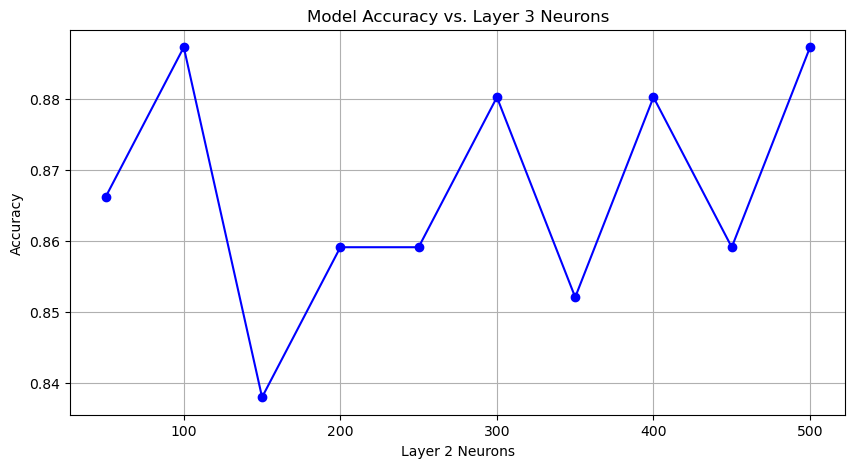

In [40]:
accuracies = []
num_neurons = []
for neurons in range(50, 501, 50):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new_10dm, X_test_10dm, y_train_new, y_test, layer1=[True, 200, 0.1], layer2 = [True, 700, 0.25], layer3=[True, neurons, 0], layer4=[False], layer5=[False])
    accuracies.append(acc)
    num_neurons.append(neurons)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_neurons, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Layer 3 Neurons')
plt.xlabel('Layer 2 Neurons')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_160 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_160 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_161 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 500)            │       150,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_162 (Activation)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 1)              │           501 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_163 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,501 (833.99 KB)

 Trainable params: 213,501 (833.99 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_164 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_164 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_165 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 525)            │       158,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_166 (Activation)     │ (None, 525)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 525)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 1)              │           526 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_167 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,051 (863.48 KB)

 Trainable params: 221,051 (863.48 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_168 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_168 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_169 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 550)            │       165,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_170 (Activation)     │ (None, 550)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 550)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 1)              │           551 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_171 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,601 (892.97 KB)

 Trainable params: 228,601 (892.97 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_172 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_172 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_173 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 575)            │       173,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_174 (Activation)     │ (None, 575)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 575)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 1)              │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_175 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,151 (922.46 KB)

 Trainable params: 236,151 (922.46 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_176 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_176 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_177 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 600)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_178 (Activation)     │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_179 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,701 (951.96 KB)

 Trainable params: 243,701 (951.96 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_180 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_181 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 625)            │       188,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_182 (Activation)     │ (None, 625)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 625)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │           626 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_183 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,251 (981.45 KB)

 Trainable params: 251,251 (981.45 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8450704216957092


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_184 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_184 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_185 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 650)            │       195,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_186 (Activation)     │ (None, 650)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 650)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 1)              │           651 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_187 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,801 (1010.94 KB)

 Trainable params: 258,801 (1010.94 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8732394576072693


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_188 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_188 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_189 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 675)            │       203,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_190 (Activation)     │ (None, 675)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 675)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 1)              │           676 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_191 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,351 (1.02 MB)

 Trainable params: 266,351 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_192 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_192 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 300)            │        60,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_193 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 700)            │       210,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_194 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 1)              │           701 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_195 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,901 (1.04 MB)

 Trainable params: 273,901 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569


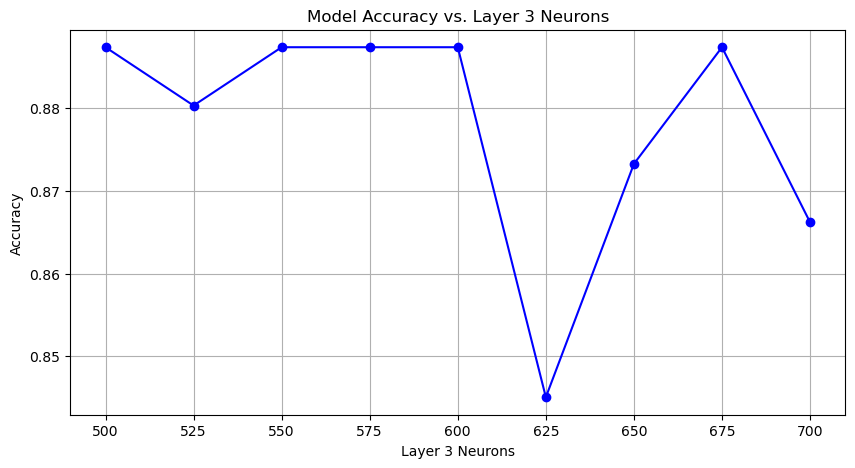

In [19]:
accuracies = []
num_neurons = []
for neurons in range(500, 701, 25):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new_10dm, X_test_10dm, y_train_new, y_test, layer1=[True, 200, 0], layer2 = [True, 300, 0], layer3=[True, neurons, 0], layer4=[False], layer5=[False])
    accuracies.append(acc)
    num_neurons.append(neurons)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_neurons, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Layer 3 Neurons')
plt.xlabel('Layer 3 Neurons')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Model: "sequential_272"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_971 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_971 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_699 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_972 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_972 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_700 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_973 (Dense)               │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_973 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_701 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_974 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_974 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569


Model: "sequential_273"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_975 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_975 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_702 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_976 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_976 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_703 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_977 (Dense)               │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_977 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_704 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_978 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_978 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045


Model: "sequential_274"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_979 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_979 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_705 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_980 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_980 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_706 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_981 (Dense)               │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_981 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_707 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_982 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_982 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8873239159584045


Model: "sequential_275"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_983 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_983 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_708 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_984 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_984 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_709 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_985 (Dense)               │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_985 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_710 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_986 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_986 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8521126508712769


Model: "sequential_276"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_987 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_987 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_711 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_988 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_988 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_712 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_989 (Dense)               │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_989 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_713 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_990 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_990 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


Model: "sequential_277"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_991 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_991 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_714 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_992 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_992 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_715 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_993 (Dense)               │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_993 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_716 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_994 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_994 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


Model: "sequential_278"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_995 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_995 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_717 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_996 (Dense)               │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_996 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_718 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_997 (Dense)               │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_997 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_719 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_998 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_998 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8732394576072693


Model: "sequential_279"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_999 (Dense)               │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_999 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_720 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1000 (Dense)              │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1000 (Activation)    │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_721 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1001 (Dense)              │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1001 (Activation)    │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_722 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1002 (Dense)              │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1002 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8732394576072693


Model: "sequential_280"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1003 (Dense)              │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1003 (Activation)    │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_723 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1004 (Dense)              │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1004 (Activation)    │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_724 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1005 (Dense)              │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1005 (Activation)    │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_725 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1006 (Dense)              │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1006 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8661971688270569


Model: "sequential_281"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1007 (Dense)              │ (None, 200)            │         2,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1007 (Activation)    │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_726 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1008 (Dense)              │ (None, 700)            │       140,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1008 (Activation)    │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_727 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1009 (Dense)              │ (None, 200)            │       140,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1009 (Activation)    │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_728 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1010 (Dense)              │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1010 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,301 (1.08 MB)

 Trainable params: 283,301 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8802816867828369


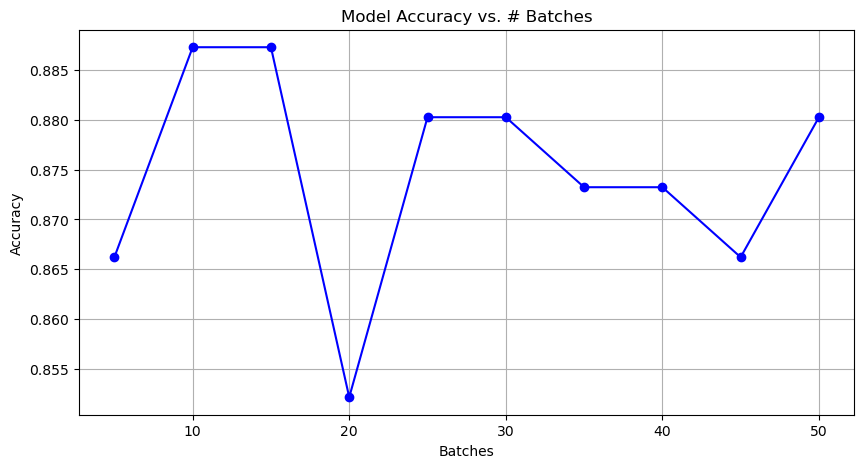

In [42]:
accuracies = []
num_batches = []
for batches in range(5, 51, 5):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new_10dm, X_test_10dm, y_train_new, y_test, layer1=[True, 200, 0.1], layer2 = [True, 700, 0.25], layer3=[True, 200, 0], layer4=[False], layer5=[False], batch=batches, rate=0.0005)
    accuracies.append(acc)
    num_batches.append(batches)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_batches, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. # Batches')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# *All Features* #

Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_396 (Dense)               │ (None, 100)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_396 (Activation)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_290 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_397 (Dense)               │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_397 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,901 (58.21 KB)

 Trainable params: 14,901 (58.21 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9436619877815247


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_398 (Dense)               │ (None, 200)            │        29,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_398 (Activation)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_291 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_399 (Dense)               │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_399 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,801 (116.41 KB)

 Trainable params: 29,801 (116.41 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_400 (Dense)               │ (None, 300)            │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_400 (Activation)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_292 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 1)              │           301 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_401 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,701 (174.61 KB)

 Trainable params: 44,701 (174.61 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_402 (Dense)               │ (None, 400)            │        59,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_402 (Activation)     │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_293 (Dropout)           │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_403 (Dense)               │ (None, 1)              │           401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_403 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,601 (232.82 KB)

 Trainable params: 59,601 (232.82 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9436619877815247


Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_404 (Dense)               │ (None, 500)            │        74,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_404 (Activation)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_294 (Dropout)           │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_405 (Dense)               │ (None, 1)              │           501 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_405 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,501 (291.02 KB)

 Trainable params: 74,501 (291.02 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_406 (Dense)               │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_406 (Activation)     │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_295 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_407 (Dense)               │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_407 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9577465057373047


Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_408 (Dense)               │ (None, 700)            │       103,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_408 (Activation)     │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_296 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 1)              │           701 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_409 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,301 (407.43 KB)

 Trainable params: 104,301 (407.43 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_410 (Dense)               │ (None, 800)            │       118,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_410 (Activation)     │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_297 (Dropout)           │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_411 (Dense)               │ (None, 1)              │           801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_411 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,201 (465.63 KB)

 Trainable params: 119,201 (465.63 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_412 (Dense)               │ (None, 900)            │       133,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_412 (Activation)     │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_298 (Dropout)           │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ (None, 1)              │           901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_413 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,101 (523.83 KB)

 Trainable params: 134,101 (523.83 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_414 (Dense)               │ (None, 1000)           │       148,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_414 (Activation)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_299 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_415 (Dense)               │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_415 (Activation)     │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,001 (582.04 KB)

 Trainable params: 149,001 (582.04 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9577465057373047


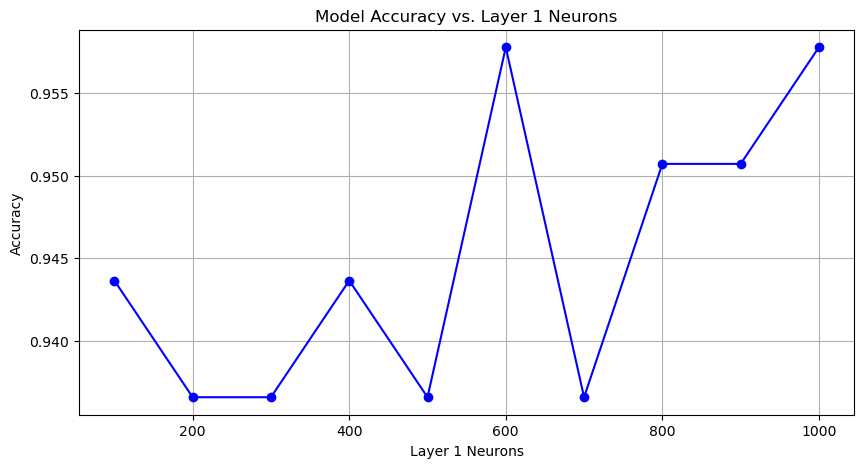

In [24]:
accuracies = []
num_neurons = []
for neurons in range(100, 1001, 100):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new, X_test, y_train_new, y_test, layer1=[True, neurons, 0], layer2 = [False], layer3=[False], layer4=[False], layer5=[False], input_size=147)
    accuracies.append(acc)
    num_neurons.append(neurons)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_neurons, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Layer 1 Neurons')
plt.xlabel('Layer 1 Neurons')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Model: "sequential_282"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1011 (Dense)              │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1011 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_729 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1012 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1012 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


Model: "sequential_283"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1013 (Dense)              │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1013 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_730 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1014 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1014 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9647887349128723


Model: "sequential_284"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1015 (Dense)              │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1015 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_731 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1016 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1016 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9647887349128723


Model: "sequential_285"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1017 (Dense)              │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1017 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_732 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1018 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1018 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9577465057373047


Model: "sequential_286"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1019 (Dense)              │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1019 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_733 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1020 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1020 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9436619877815247


Model: "sequential_287"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1021 (Dense)              │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1021 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_734 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1022 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1022 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9436619877815247


Model: "sequential_288"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1023 (Dense)              │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1023 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_735 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1024 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1024 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


Model: "sequential_289"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1025 (Dense)              │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1025 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_736 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1026 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1026 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


Model: "sequential_290"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1027 (Dense)              │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1027 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_737 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1028 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1028 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9577465057373047


Model: "sequential_291"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1029 (Dense)              │ (None, 600)            │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1029 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_738 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1030 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1030 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,401 (349.22 KB)

 Trainable params: 89,401 (349.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


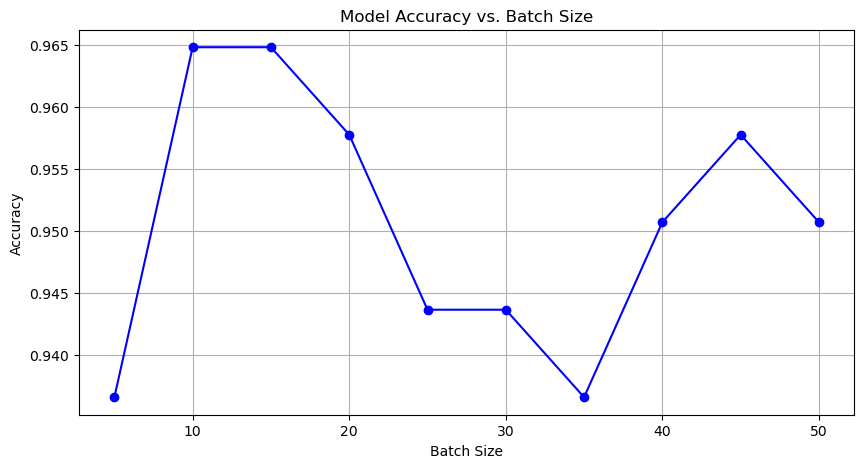

In [44]:
accuracies = []
num_batches = []
for batches in range(5, 51, 5):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new, X_test, y_train_new, y_test, layer1=[True, 600, 0], layer2 = [False], layer3=[False], layer4=[False], layer5=[False], input_size=147, batch=batches)
    accuracies.append(acc)
    num_batches.append(batches)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_batches, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# *PCA* #

Model: "sequential_305"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1057 (Dense)              │ (None, 600)            │         6,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1057 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_752 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1058 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1058 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,201 (28.13 KB)

 Trainable params: 7,201 (28.13 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8309859037399292


Model: "sequential_306"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1059 (Dense)              │ (None, 600)            │        15,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1059 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_753 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1060 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1060 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,201 (63.29 KB)

 Trainable params: 16,201 (63.29 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9154929518699646


Model: "sequential_307"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1061 (Dense)              │ (None, 600)            │        24,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1061 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_754 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1062 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1062 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,201 (98.44 KB)

 Trainable params: 25,201 (98.44 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.908450722694397


Model: "sequential_308"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1063 (Dense)              │ (None, 600)            │        33,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1063 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_755 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1064 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1064 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,201 (133.60 KB)

 Trainable params: 34,201 (133.60 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


Model: "sequential_309"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1065 (Dense)              │ (None, 600)            │        42,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1065 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_756 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1066 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1066 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,201 (168.75 KB)

 Trainable params: 43,201 (168.75 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


Model: "sequential_310"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1067 (Dense)              │ (None, 600)            │        51,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1067 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_757 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1068 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1068 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,201 (203.91 KB)

 Trainable params: 52,201 (203.91 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9154929518699646


Model: "sequential_311"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1069 (Dense)              │ (None, 600)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1069 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_758 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1070 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1070 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,201 (239.07 KB)

 Trainable params: 61,201 (239.07 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177


Model: "sequential_312"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1071 (Dense)              │ (None, 600)            │        69,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1071 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_759 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1072 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1072 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,201 (274.22 KB)

 Trainable params: 70,201 (274.22 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9154929518699646


Model: "sequential_313"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1073 (Dense)              │ (None, 600)            │        78,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1073 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_760 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1074 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1074 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,201 (309.38 KB)

 Trainable params: 79,201 (309.38 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9295774698257446


Model: "sequential_314"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1075 (Dense)              │ (None, 600)            │        87,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1075 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_761 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1076 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1076 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,201 (344.54 KB)

 Trainable params: 88,201 (344.54 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177


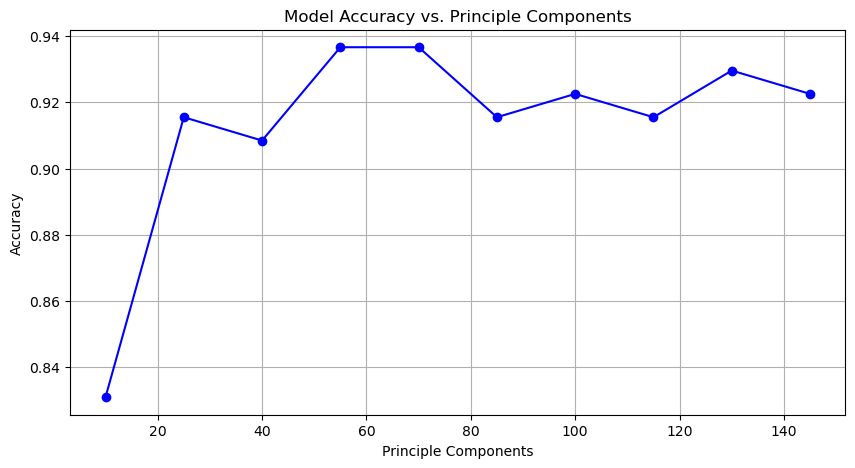

In [48]:
accuracies = []
num_pc = []
for pc in range(10, 146, 15):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new, X_test, y_train_new, y_test, layer1=[True, 600, 0], layer2 = [False], layer3=[False], layer4=[False], layer5=[False], input_size=pc, pca=True, n_pc=pc)
    accuracies.append(acc)
    num_pc.append(pc)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_pc, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Principle Components')
plt.xlabel('Principle Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Model: "sequential_315"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1077 (Dense)              │ (None, 200)            │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1077 (Activation)    │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_762 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1078 (Dense)              │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1078 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,401 (48.44 KB)

 Trainable params: 12,401 (48.44 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9577465057373047


Model: "sequential_316"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1079 (Dense)              │ (None, 400)            │        24,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1079 (Activation)    │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_763 (Dropout)           │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1080 (Dense)              │ (None, 1)              │           401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1080 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801 (96.88 KB)

 Trainable params: 24,801 (96.88 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


Model: "sequential_317"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1081 (Dense)              │ (None, 600)            │        36,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1081 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_764 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1082 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1082 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,201 (145.32 KB)

 Trainable params: 37,201 (145.32 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9577465057373047


Model: "sequential_318"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1083 (Dense)              │ (None, 800)            │        48,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1083 (Activation)    │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_765 (Dropout)           │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1084 (Dense)              │ (None, 1)              │           801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1084 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,601 (193.75 KB)

 Trainable params: 49,601 (193.75 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9577465057373047


Model: "sequential_319"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1085 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1085 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_766 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1086 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1086 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9647887349128723


Model: "sequential_320"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1087 (Dense)              │ (None, 1200)           │        73,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1087 (Activation)    │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_767 (Dropout)           │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1088 (Dense)              │ (None, 1)              │         1,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1088 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,401 (290.63 KB)

 Trainable params: 74,401 (290.63 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


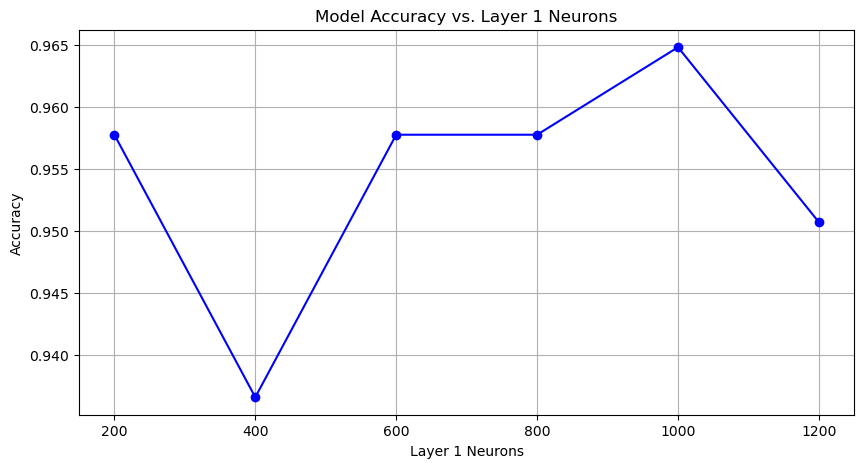

In [49]:
accuracies = []
num_neurons = []
for neurons in range(200, 1201, 200):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new, X_test, y_train_new, y_test, layer1=[True, neurons, 0], layer2 = [False], layer3=[False], layer4=[False], layer5=[False], input_size=60, pca=True, n_pc=60)
    accuracies.append(acc)
    num_neurons.append(neurons)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_neurons, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Layer 1 Neurons')
plt.xlabel('Layer 1 Neurons')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Model: "sequential_321"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1089 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1089 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_768 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1090 (Dense)              │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1090 (Activation)    │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_769 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1091 (Dense)              │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1091 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,201 (629.69 KB)

 Trainable params: 161,201 (629.69 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


Model: "sequential_322"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1092 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1092 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_770 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1093 (Dense)              │ (None, 200)            │       200,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1093 (Activation)    │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_771 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1094 (Dense)              │ (None, 1)              │           201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1094 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,401 (1021.10 KB)

 Trainable params: 261,401 (1021.10 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9436619877815247


Model: "sequential_323"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1095 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1095 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_772 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1096 (Dense)              │ (None, 300)            │       300,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1096 (Activation)    │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_773 (Dropout)           │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1097 (Dense)              │ (None, 1)              │           301 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1097 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,601 (1.38 MB)

 Trainable params: 361,601 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


Model: "sequential_324"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1098 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1098 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_774 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1099 (Dense)              │ (None, 400)            │       400,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1099 (Activation)    │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_775 (Dropout)           │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1100 (Dense)              │ (None, 1)              │           401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1100 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,801 (1.76 MB)

 Trainable params: 461,801 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9436619877815247


Model: "sequential_325"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1101 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1101 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_776 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1102 (Dense)              │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1102 (Activation)    │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_777 (Dropout)           │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1103 (Dense)              │ (None, 1)              │           501 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1103 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 562,001 (2.14 MB)

 Trainable params: 562,001 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9436619877815247


Model: "sequential_326"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1104 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1104 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_778 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1105 (Dense)              │ (None, 600)            │       600,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1105 (Activation)    │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_779 (Dropout)           │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1106 (Dense)              │ (None, 1)              │           601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1106 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,201 (2.53 MB)

 Trainable params: 662,201 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9577465057373047


Model: "sequential_327"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1107 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1107 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_780 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1108 (Dense)              │ (None, 700)            │       700,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1108 (Activation)    │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_781 (Dropout)           │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1109 (Dense)              │ (None, 1)              │           701 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1109 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 762,401 (2.91 MB)

 Trainable params: 762,401 (2.91 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


Model: "sequential_328"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1110 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1110 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_782 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1111 (Dense)              │ (None, 800)            │       800,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1111 (Activation)    │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_783 (Dropout)           │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1112 (Dense)              │ (None, 1)              │           801 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1112 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 862,601 (3.29 MB)

 Trainable params: 862,601 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177


Model: "sequential_329"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1113 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1113 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_784 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1114 (Dense)              │ (None, 900)            │       900,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1114 (Activation)    │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_785 (Dropout)           │ (None, 900)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1115 (Dense)              │ (None, 1)              │           901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1115 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 962,801 (3.67 MB)

 Trainable params: 962,801 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9295774698257446


Model: "sequential_330"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1116 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1116 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_786 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1117 (Dense)              │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1117 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_787 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1118 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1118 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,063,001 (4.06 MB)

 Trainable params: 1,063,001 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9436619877815247


Model: "sequential_331"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1119 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1119 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_788 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1120 (Dense)              │ (None, 1100)           │     1,101,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1120 (Activation)    │ (None, 1100)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_789 (Dropout)           │ (None, 1100)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1121 (Dense)              │ (None, 1)              │         1,101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1121 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,163,201 (4.44 MB)

 Trainable params: 1,163,201 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


Model: "sequential_332"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1122 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1122 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_790 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1123 (Dense)              │ (None, 1200)           │     1,201,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1123 (Activation)    │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_791 (Dropout)           │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1124 (Dense)              │ (None, 1)              │         1,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1124 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,263,401 (4.82 MB)

 Trainable params: 1,263,401 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9366196990013123


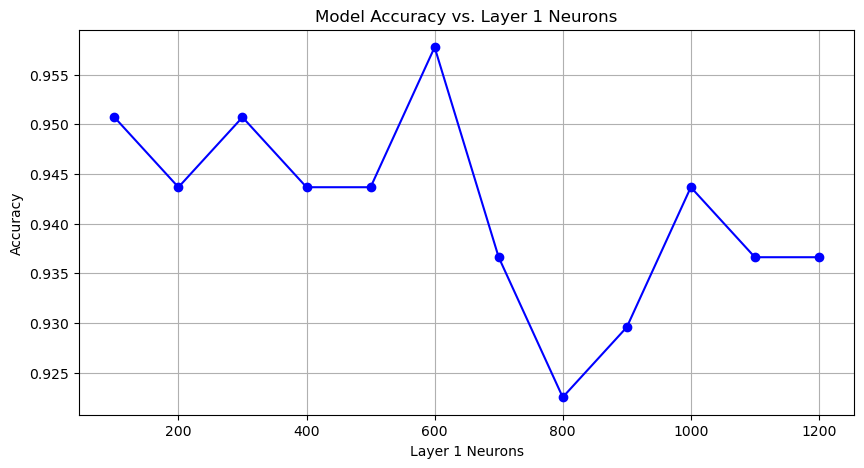

In [50]:
accuracies = []
num_neurons = []
for neurons in range(100, 1201, 100):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new, X_test, y_train_new, y_test, layer1=[True, 1000, 0], layer2 = [True, neurons, 0], layer3=[False], layer4=[False], layer5=[False], input_size=60, pca=True, n_pc=60)
    accuracies.append(acc)
    num_neurons.append(neurons)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_neurons, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Layer 1 Neurons')
plt.xlabel('Layer 1 Neurons')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Model: "sequential_333"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1125 (Dense)              │ (None, 1000)           │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1125 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_792 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1126 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1126 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,001 (46.88 KB)

 Trainable params: 12,001 (46.88 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.8309859037399292


Model: "sequential_334"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1127 (Dense)              │ (None, 1000)           │        26,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1127 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_793 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1128 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1128 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,001 (105.47 KB)

 Trainable params: 27,001 (105.47 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.908450722694397


Model: "sequential_335"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1129 (Dense)              │ (None, 1000)           │        41,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1129 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_794 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1130 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1130 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,001 (164.07 KB)

 Trainable params: 42,001 (164.07 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9154929518699646


Model: "sequential_336"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1131 (Dense)              │ (None, 1000)           │        56,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1131 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_795 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1132 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1132 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,001 (222.66 KB)

 Trainable params: 57,001 (222.66 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9436619877815247


Model: "sequential_337"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1133 (Dense)              │ (None, 1000)           │        71,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1133 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_796 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1134 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1134 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,001 (281.25 KB)

 Trainable params: 72,001 (281.25 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9295774698257446


Model: "sequential_338"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1135 (Dense)              │ (None, 1000)           │        86,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1135 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_797 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1136 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1136 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,001 (339.85 KB)

 Trainable params: 87,001 (339.85 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177


Model: "sequential_339"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1137 (Dense)              │ (None, 1000)           │       101,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1137 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_798 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1138 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1138 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,001 (398.44 KB)

 Trainable params: 102,001 (398.44 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177


Model: "sequential_340"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1139 (Dense)              │ (None, 1000)           │       116,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1139 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_799 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1140 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1140 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,001 (457.04 KB)

 Trainable params: 117,001 (457.04 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.908450722694397


Model: "sequential_341"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1141 (Dense)              │ (None, 1000)           │       131,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1141 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_800 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1142 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1142 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,001 (515.63 KB)

 Trainable params: 132,001 (515.63 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.922535240650177


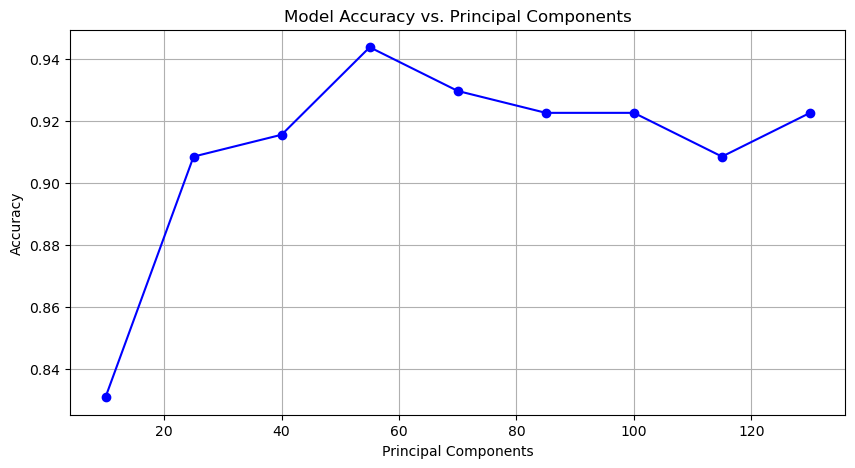

In [51]:
accuracies = []
num_pc = []
for pc in range(10, 145, 15):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new, X_test, y_train_new, y_test, layer1=[True, 1000, 0], layer2 = [False], layer3=[False], layer4=[False], layer5=[False], input_size=pc, pca=True, n_pc=pc)
    accuracies.append(acc)
    num_pc.append(pc)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_pc, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Model: "sequential_342"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1143 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1143 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_801 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1144 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1144 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


Model: "sequential_343"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1145 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1145 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_802 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1146 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1146 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


Model: "sequential_344"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1147 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1147 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_803 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1148 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1148 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9577465057373047


Model: "sequential_345"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1149 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1149 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_804 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1150 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1150 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


Model: "sequential_346"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1151 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1151 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_805 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1152 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1152 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


Model: "sequential_347"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1153 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1153 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_806 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1154 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1154 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9577465057373047


Model: "sequential_348"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1155 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1155 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_807 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1156 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1156 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9436619877815247


Model: "sequential_349"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1157 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1157 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_808 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1158 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1158 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9577465057373047


Model: "sequential_350"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1159 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1159 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_809 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1160 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1160 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9507042169570923


Model: "sequential_351"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1161 (Dense)              │ (None, 1000)           │        61,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1161 (Activation)    │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_810 (Dropout)           │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1162 (Dense)              │ (None, 1)              │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1162 (Activation)    │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,001 (242.19 KB)

 Trainable params: 62,001 (242.19 KB)

 Non-trainable params: 0 (0.00 B)

Test Accuracy: 0.9647887349128723


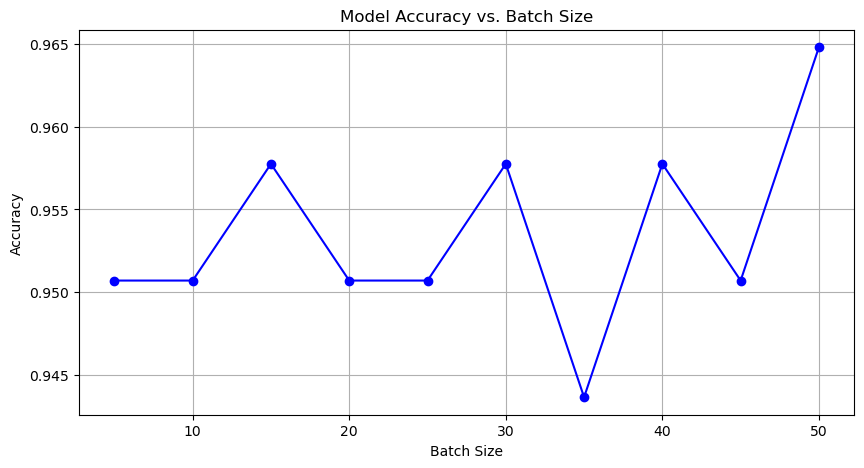

In [52]:
accuracies = []
num_batches = []
for batch in range(5, 51, 5):  # Directly iterate over the range without wrapping it in a list
    acc = evaluate_deep_model(X_train_new, X_test, y_train_new, y_test, layer1=[True, 1000, 0], layer2 = [False], layer3=[False], layer4=[False], layer5=[False], input_size=60, pca=True, n_pc=60, epochs=100, batch=batch)
    accuracies.append(acc)
    num_batches.append(batch)  

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(num_batches, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()